Processa e limpa dados de estabelecimentos para 2007, 2010, 2015

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from pathlib import Path
import warnings

# Suprimir avisos de leitura do pandas (warnings irrelevantes)
warnings.filterwarnings('ignore')

# Configuracoes visuais
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Caminhos
# Ajuste se necessario para o seu ambiente
RAW_PATH = Path('../data/raw/cnes')
PROCESSED_PATH = Path('../data/processed')
PROCESSED_PATH.mkdir(exist_ok=True, parents=True)

print("Ambiente configurado com sucesso.")

Ambiente configurado com sucesso.


Processamento Estabelecimentos

In [15]:
def processar_estabelecimentos(ano):
    print(f'\n=== Processando Estabelecimentos {ano} ===')
    
    # Construcao do nome do arquivo: cnes_estabelecimentos_2007.csv
    file_name = f'cnes_estabelecimentos_{ano}.csv'
    file_path = RAW_PATH / file_name
    
    if not file_path.exists():
        print(f'[ERRO] Arquivo nao encontrado: {file_path}')
        return pd.DataFrame()

    # Carregar dados
    # Tabnet usa encoding latin1, separador ponto-e-virgula, pular 3 linhas iniciais e rodape
    try:
        df = pd.read_csv(file_path, encoding='latin1', sep=';', skiprows=3, skipfooter=10, engine='python')
    except Exception as e:
        print(f'[ERRO] Falha ao ler CSV: {e}')
        return pd.DataFrame()
    
    print(f'Shape original: {df.shape}')
    
    # Identificacao dinamica das colunas (Primeira e Municipio, Ultima e Quantidade)
    col_municipio_raw = df.columns[0]  # Coluna com Codigo + Nome
    col_quantidade_raw = df.columns[-1] # Coluna com Valor
    
    print(f'Colunas identificadas: {col_municipio_raw} | {col_quantidade_raw}')

    # Analise de qualidade inicial (Diagnostico)
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print('[AVISO] Valores nulos encontrados antes da limpeza:')
        print(missing[missing > 0])
    else:
        print('[INFO] Nenhum valor nulo encontrado na carga bruta.')

    # Criacao do DataFrame limpo
    df_clean = pd.DataFrame()

    # 1. Tratamento da Coluna Municipio (Separar Codigo 6 digitos e Nome)
    # Exemplo: "110001 ALTA FLORESTA"
    try:
        df_clean['codmun'] = df[col_municipio_raw].astype(str).str.slice(0, 6)
        df_clean['nome_municipio'] = df[col_municipio_raw].astype(str).str.slice(7).str.strip()
    except Exception as e:
        print(f'[ERRO] Falha ao processar coluna municipio: {e}')
        return pd.DataFrame()

    # 2. Tratamento da Coluna Quantidade
    # Tabnet usa '-' para representar zero
    df_clean['estabelecimentos'] = df[col_quantidade_raw].replace('-', 0)
    df_clean['estabelecimentos'] = pd.to_numeric(df_clean['estabelecimentos'], errors='coerce').fillna(0).astype(int)

    # 3. Adicionar Ano
    df_clean['ano'] = int(ano)

    # Filtrar apenas codigos validos (tamanho 6)
    df_clean = df_clean[df_clean['codmun'].str.len() == 6]

    print(f'Shape apos limpeza: {df_clean.shape}')
    
    return df_clean

execução e consolidação

In [16]:
# Lista para armazenar os dataframes de cada ano
dfs_estabelecimentos = []

# Loop pelos anos
for ano_ref in [2007, 2010, 2015]:
    df_ano = processar_estabelecimentos(ano_ref)
    if not df_ano.empty:
        dfs_estabelecimentos.append(df_ano)

# Consolidar todos os anos
if dfs_estabelecimentos:
    df_final = pd.concat(dfs_estabelecimentos, ignore_index=True)
    
    print('\n=== Dataset Final Consolidado ===')
    print(f'Shape Total: {df_final.shape}')
    
    # Salvar em Parquet
    output_file = PROCESSED_PATH / 'cnes_estabelecimentos_clean.parquet'
    df_final.to_parquet(output_file, index=False)
    print(f'[SUCESSO] Dataset salvo em: {output_file}')
else:
    print('[ERRO] Nenhum dado foi processado. Verifique os arquivos.')


=== Processando Estabelecimentos 2007 ===
Shape original: (5564, 2)
Colunas identificadas: Município | Quantidade
[INFO] Nenhum valor nulo encontrado na carga bruta.
Shape apos limpeza: (5564, 4)

=== Processando Estabelecimentos 2010 ===
Shape original: (5565, 2)
Colunas identificadas: Município | Quantidade
[INFO] Nenhum valor nulo encontrado na carga bruta.
Shape apos limpeza: (5565, 4)

=== Processando Estabelecimentos 2015 ===
Shape original: (5570, 2)
Colunas identificadas: Município | Quantidade
[INFO] Nenhum valor nulo encontrado na carga bruta.
Shape apos limpeza: (5570, 4)

=== Dataset Final Consolidado ===
Shape Total: (16699, 4)
[SUCESSO] Dataset salvo em: ../data/processed/cnes_estabelecimentos_clean.parquet


Analisando com DunckDB 

In [17]:
print('\n=== Validacao e Diagnostico com DuckDB ===')

# Conectar ao DuckDB em memoria
con = duckdb.connect()

# Registrar o dataframe pandas como uma tabela virtual no DuckDB
con.register('tb_estabelecimentos', df_final)

# Consulta 1: Resumo por Ano (Integridade Temporal)
query_resumo = """
SELECT 
    ano,
    COUNT(*) as qtd_municipios,
    SUM(estabelecimentos) as total_estabelecimentos,
    AVG(estabelecimentos)::INT as media_por_cidade,
    MAX(estabelecimentos) as maximo_cidade
FROM tb_estabelecimentos
GROUP BY ano
ORDER BY ano
"""
print('\n[SQL] Resumo Estatistico por Ano:')
print(con.execute(query_resumo).df())

# Consulta 2: Verificacao de Integridade (Valores Negativos)
query_check = """
SELECT *
FROM tb_estabelecimentos
WHERE estabelecimentos < 0
"""
df_check = con.execute(query_check).df()
if df_check.empty:
    print('\n[SQL] Integridade Aprovada: Nenhum valor negativo encontrado.')
else:
    print('\n[SQL] ALERTA: Valores negativos encontrados!')
    print(df_check)

# Consulta 3: Top 5 Municipios em 2015 (Validacao de Consistencia)
query_top = """
SELECT codmun, nome_municipio, estabelecimentos
FROM tb_estabelecimentos
WHERE ano = 2015
ORDER BY estabelecimentos DESC
LIMIT 5
"""
print('\n[SQL] Top 5 Municipios com mais estabelecimentos (2015):')
print(con.execute(query_top).df())


=== Validacao e Diagnostico com DuckDB ===

[SQL] Resumo Estatistico por Ano:
    ano  qtd_municipios  total_estabelecimentos  media_por_cidade  \
0  2007            5564                170982.0                31   
1  2010            5565                224191.0                40   
2  2015            5570                286011.0                51   

   maximo_cidade  
0           8695  
1          12562  
2          17204  

[SQL] Integridade Aprovada: Nenhum valor negativo encontrado.

[SQL] Top 5 Municipios com mais estabelecimentos (2015):
   codmun  nome_municipio  estabelecimentos
0  355030       SAO PAULO             17204
1  330455  RIO DE JANEIRO              6267
2  410690        CURITIBA              5664
3  310620  BELO HORIZONTE              5590
4  530010        BRASILIA              5428


visualiazação grafica

[INFO] Grafico de diagnostico salvo em: ../data/processed/diagnostico_estabelecimentos.png


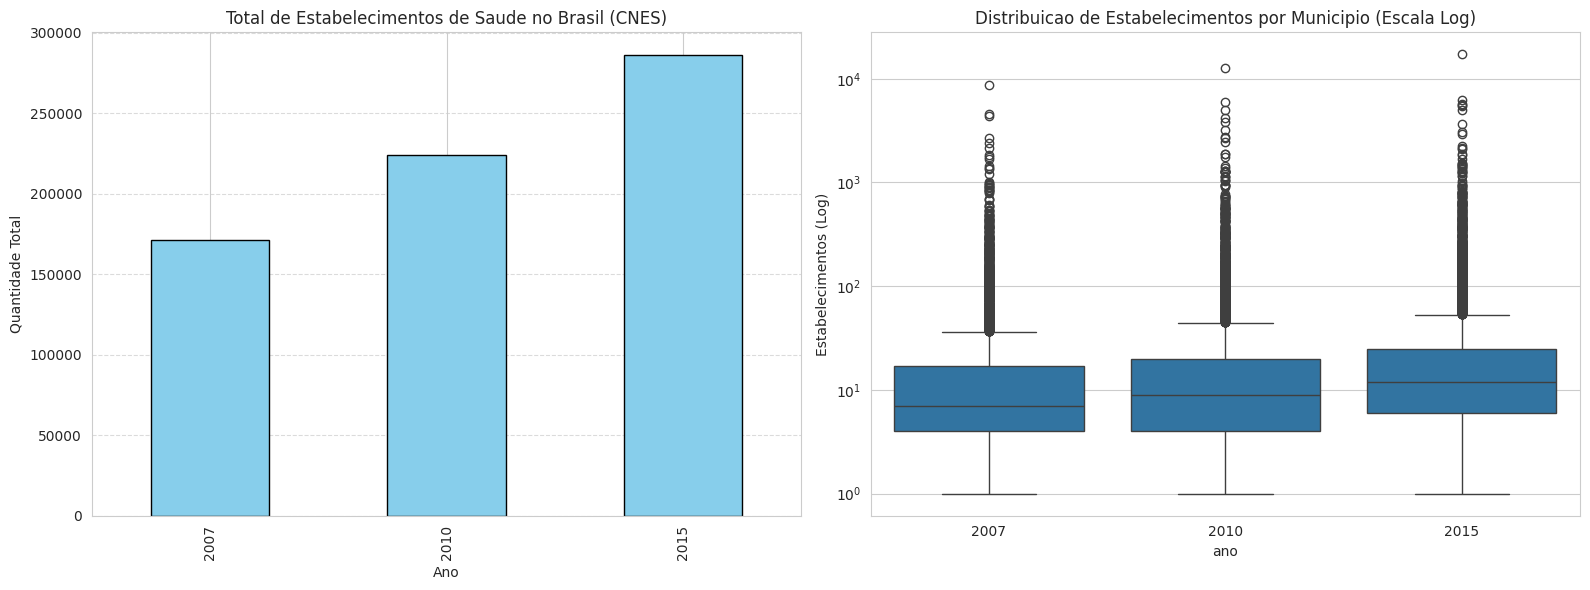

In [18]:
# Configurar plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Evolucao Total de Estabelecimentos
total_por_ano = df_final.groupby('ano')['estabelecimentos'].sum()
total_por_ano.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Total de Estabelecimentos de Saude no Brasil (CNES)')
axes[0].set_ylabel('Quantidade Total')
axes[0].set_xlabel('Ano')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Grafico 2: Boxplot para detectar Outliers (Distribuicao)
# Usamos escala logaritmica porque SP e Rio distorcem muito o grafico normal
sns.boxplot(x='ano', y='estabelecimentos', data=df_final, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Distribuicao de Estabelecimentos por Municipio (Escala Log)')
axes[1].set_ylabel('Estabelecimentos (Log)')

plt.tight_layout()

# Salvar imagem para o relatorio
img_path = PROCESSED_PATH / 'diagnostico_estabelecimentos.png'
plt.savefig(img_path)
print(f'[INFO] Grafico de diagnostico salvo em: {img_path}')

plt.show()

## Processamento Leitos

In [ ]:
def processar_leitos(ano):
    print(f'\n=== Processando Leitos {ano} ===')
    
    # Nome do arquivo padronizado (usa o seu RAW_PATH ja definido)
    file_name = f'cnes_leitos_{ano}.csv'
    file_path = RAW_PATH / file_name
    
    if not file_path.exists():
        print(f'[ERRO] Arquivo nao encontrado: {file_path}')
        return pd.DataFrame()

    # Leitura do Tabnet
    try:
        df = pd.read_csv(file_path, encoding='latin1', sep=';', skiprows=3, skipfooter=10, engine='python')
    except:
        df = pd.read_csv(file_path, encoding='utf-8', sep=';', skiprows=3, skipfooter=10, engine='python')
    
    # Identificacao de colunas (Dinamica pela posicao)
    # Coluna 0: Municipio (Codigo + Nome) | Coluna -1: Quantidade_SUS
    col_municipio_raw = df.columns[0]
    col_quantidade_raw = df.columns[-1]
    
    print(f'Colunas identificadas: {col_municipio_raw} | {col_quantidade_raw}')
    
    df_clean = pd.DataFrame()

    # 1. Tratamento Municipio (Separar Codigo e Nome)
    try:
        df_clean['codmun'] = df[col_municipio_raw].astype(str).str.slice(0, 6)
        df_clean['nome_municipio'] = df[col_municipio_raw].astype(str).str.slice(7).str.strip()
    except:
        return pd.DataFrame()

    # 2. Tratamento Quantidade (Leitos SUS)
    df_clean['leitos_sus'] = df[col_quantidade_raw].replace('-', 0)
    df_clean['leitos_sus'] = pd.to_numeric(df_clean['leitos_sus'], errors='coerce').fillna(0).astype(int)

    # 3. Metadados
    df_clean['ano'] = int(ano)
    df_clean = df_clean[df_clean['codmun'].str.len() == 6]
    
    return df_clean

# Execucao em Lote
dfs_leitos = []
for ano_ref in [2007, 2010, 2015]:
    df_ano = processar_leitos(ano_ref)
    if not df_ano.empty:
        dfs_leitos.append(df_ano)

# Consolidar, Salvar e Validar
if dfs_leitos:
    df_leitos_final = pd.concat(dfs_leitos, ignore_index=True)
    
    output_file = PROCESSED_PATH / 'cnes_leitos_clean.parquet'
    df_leitos_final.to_parquet(output_file, index=False)
    
    print('\n=== Dataset Leitos Finalizado ===')
    print(f'[SUCESSO] Salvo em: {output_file}')
    
    # Validacao SQL (DuckDB)
    print('\n[SQL] Resumo de Leitos por Ano:')
    con = duckdb.connect()
    print(con.execute("SELECT ano, SUM(leitos_sus) as total_leitos FROM df_leitos_final GROUP BY ano ORDER BY ano").df())